# introductory text (explain: dataset, task)

MathE is an adaptive mathematics learning tool. When students log in to the training area of mathE, they choose a topic to study and specify whether they prefer basic or advanced questions. The platform then selects a set of seven multiple-choice questions based on their preference and generates a test for the student. After completing and submitting the test, the answers are recorded and stored. My dataset consists of 9546 answers to 833 questions provided by 372 students from 8 countries who have used the platform.

My task is to predict whether a question will be answered correctly or not given the student, country, question, difficulty, topic, etc.

References:
MathE Platform: https://mathe.ipb.pt/homePage
Abstract on Dataset Contents: https://pubmed.ncbi.nlm.nih.gov/38445202/
Dataset Download: https://archive.ics.uci.edu/dataset/1031/dataset+for+assessing+mathematics+learning+in+higher+education

I have included my trial and error results to help demonstrate my thought process despite not being polished for presentation

# import requisite modules

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

# pre-process, analyze dataset

In [141]:
df = pd.read_csv("MathE_dataset.csv", sep = ';', encoding='ISO-8859-1')

In [142]:
Basicdf = pd.read_csv("MathE_dataset.csv", sep=';', encoding='ISO-8859-1')
y = Basicdf['Type of Answer']

categorical_cols = ['Student Country', 'Question Level', 'Topic', 'Subtopic', 'Keywords']
numeric_cols = ['Student ID', 'Question ID']

X_encoded_cat_df = pd.DataFrame()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded_cat_df[col] = le.fit_transform(Basicdf[col])

X_numeric_df = Basicdf[numeric_cols]
X_processed = pd.concat([X_encoded_cat_df, X_numeric_df], axis=1)
Basicdf = X_processed.copy()
Basicdf['Type of Answer'] = y.values

Basicdf.to_csv('MathE_dataset_original.csv', index=False)


In [143]:
#Abandoned this manual approach once I found MultiLabelBinarizer
Manualdf = pd.read_csv("MathE_dataset.csv", sep = ';', encoding='ISO-8859-1')
uniqueKeywords = set()
for i, keywords in enumerate(Manualdf['Keywords']):
    keyList = keywords.split(',')
    Manualdf.at[i,'Keywords'] = keyList
    for topic in Manualdf['Keywords'][i]:
        uniqueKeywords.add(topic)

i = 0
topics = {}
for i, topic in enumerate(uniqueKeywords):
    topics[topic] = i
    
for i, row in enumerate(Manualdf['Keywords']):
    binaryEncoding = ['0'] * 194
    for topic in row:
        index = topics[topic]
        binaryEncoding[index] = '1'
    Manualdf.at[i, 'Keywords'] = binaryEncoding
Manualdf.to_csv('MathE_dataset_manual.csv', index = None)

In [144]:
#MultiLabelBinarizer approach
MLBdf = pd.read_csv("MathE_dataset.csv", sep=';', encoding='ISO-8859-1')
MLBdf['Keywords'] = MLBdf['Keywords'].str.split(',')

#convert to binary labels
mlb = MultiLabelBinarizer()
keywords_encoded = mlb.fit_transform(MLBdf['Keywords'])

#convert back to dataframe
keywords_df = pd.DataFrame(keywords_encoded, columns=mlb.classes_)
MLBdf = Basicdf.drop(columns=['Keywords']).join(keywords_df)
MLBdf.to_csv('MathE_dataset_MLB.csv', index = None)

In [145]:
#TF-IDF approach
TFIDFdf = pd.read_csv("MathE_dataset.csv", sep=';', encoding='ISO-8859-1')

TFIDFdf['Keywords'] = TFIDFdf['Keywords'].str.replace(' ', '')
TFIDFdf['Keywords'] = TFIDFdf['Keywords'].str.split(',').str.join(' ')

vectorizer = TfidfVectorizer()
keywords_tfidf = vectorizer.fit_transform(TFIDFdf['Keywords'])

keywords_df = pd.DataFrame(keywords_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
TFIDFdf = Basicdf.drop(columns=['Keywords']).join(keywords_df)

TFIDFdf.to_csv('MathE_dataset_TFIDF.csv', index=False)

In [146]:
#TF-IDF with dimensionality reduction
TFIDF_DRdf = pd.read_csv("MathE_dataset.csv", sep=';', encoding='ISO-8859-1')

TFIDF_DRdf['Keywords'] = TFIDF_DRdf['Keywords'].str.replace(' ', '')
TFIDF_DRdf['Keywords'] = TFIDF_DRdf['Keywords'].str.split(',').str.join(' ')

vectorizer = TfidfVectorizer()
keywords_tfidf = vectorizer.fit_transform(TFIDF_DRdf['Keywords'])

svd = TruncatedSVD(n_components=1, random_state=42)
keywords_reduced = svd.fit_transform(keywords_tfidf)

TFIDF_DRdf = Basicdf.drop(columns=['Keywords']).copy()
TFIDF_DRdf['Keywords_SVD'] = keywords_reduced

TFIDF_DRdf.to_csv('MathE_dataset_TFIDF.csv', index=False)

# visualize dataset

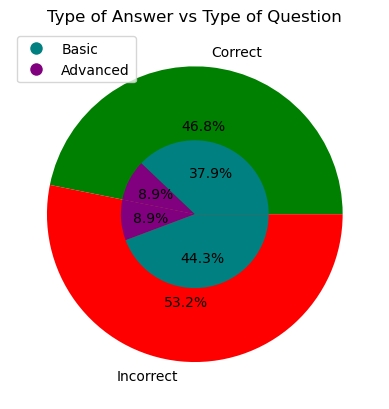

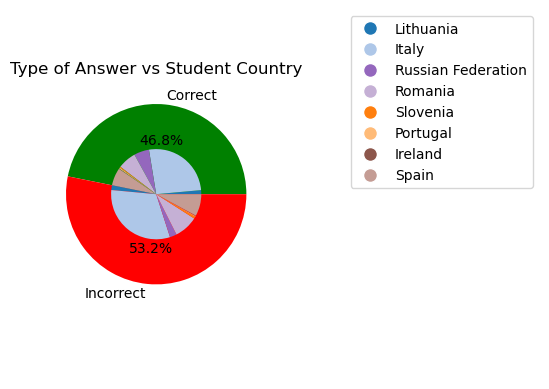

In [148]:
#Once I made the 2nd pie chart, I realized how undescriptive these were and that bar charts were a better approach
#(the second one shows more the proportions of countries to each other rather than how well they perform)

plt.figure()
plt.title("Type of Answer vs Type of Question")

maskCorrect = df["Type of Answer"] == 1
correct = df["Type of Answer"][maskCorrect].size
incorrect = df["Type of Answer"][~maskCorrect].size
plt.pie([correct, incorrect], labels=["Correct", "Incorrect"], autopct="%1.1f%%", colors = ["green", "red"])

correct_basic = (df[(df["Type of Answer"] == 1) & (df["Question Level"] == "Basic")]).shape[0]
incorrect_basic = (df[(df["Type of Answer"] == 0) & (df["Question Level"] == "Basic")]).shape[0]
correct_Advanced = (df[(df["Type of Answer"] == 1) & (df["Question Level"] == "Advanced")]).shape[0]
incorrect_Advanced = (df[(df["Type of Answer"] == 0) & (df["Question Level"] == "Advanced")]).shape[0]
plt.pie([correct_basic, correct_Advanced, incorrect_Advanced, incorrect_basic], autopct = "%1.1f%%", radius = 0.5, colors=["teal","purple","purple","teal"])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='teal', markersize=10, label='Basic'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Advanced')
]
plt.legend(handles=handles, loc="best")
plt.show()



plt.figure()
plt.subplot(1,2,1)
plt.title("Type of Answer vs Student Country")

maskCorrect = df["Type of Answer"] == 1
correct = df["Type of Answer"][maskCorrect].size
incorrect = df["Type of Answer"][~maskCorrect].size
plt.pie([correct, incorrect], labels=["Correct", "Incorrect"], autopct="%1.1f%%", colors = ["green", "red"])
uniqueCountries = set()
countryAnswers = {}
for country in df['Student Country']:
    uniqueCountries.add(country)
for country in uniqueCountries:
    countryAnswers[country + "Correct"] = (df[(df["Type of Answer"] == 1) & (df["Student Country"] == country)]).shape[0]
for country in uniqueCountries:
    countryAnswers[country + "Incorrect"] = (df[(df["Type of Answer"] == 0) & (df["Student Country"] == country)]).shape[0]
_,_ = plt.pie(countryAnswers.values(), radius = 0.5, colors = ["#1f77b4","#aec7e8","#9467bd","#c5b0d5","#ff7f0e","#ffbb78","#8c564b","#c49c94","#1f77b4","#aec7e8","#9467bd","#c5b0d5","#ff7f0e","#ffbb78","#8c564b","#c49c94"])

plt.subplot(1,2,2)
plt.axis('off')
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#1f77b4", markersize=10, label='Lithuania'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#aec7e8', markersize=10, label='Italy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#9467bd', markersize=10, label='Russian Federation'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c5b0d5', markersize=10, label='Romania'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10, label='Slovenia'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffbb78', markersize=10, label='Portugal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8c564b', markersize=10, label='Ireland'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c49c94', markersize=10, label='Spain')
]
plt.legend(handles=handles, loc="best")


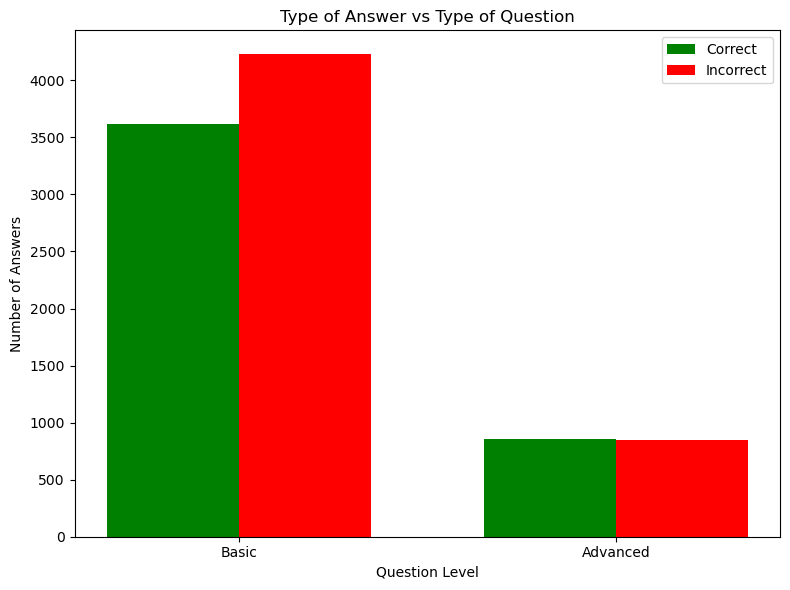

In [204]:
#Type of Answer VS Type of Question
correct_basic = df[(df["Type of Answer"] == 1) & (df["Question Level"] == "Basic")].shape[0]
incorrect_basic = df[(df["Type of Answer"] == 0) & (df["Question Level"] == "Basic")].shape[0]
correct_advanced = df[(df["Type of Answer"] == 1) & (df["Question Level"] == "Advanced")].shape[0]
incorrect_advanced = df[(df["Type of Answer"] == 0) & (df["Question Level"] == "Advanced")].shape[0]

labels = ["Basic", "Advanced"]
correct_counts = [correct_basic, correct_advanced]
incorrect_counts = [incorrect_basic, incorrect_advanced]

x = list(range(len(labels)))
bar_width = 0.35
x_correct = []
x_incorrect = []
for i in x:
    x_correct.append(i - bar_width / 2)
    x_incorrect.append(i + bar_width / 2)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x_correct, correct_counts, width=bar_width, label="Correct", color="green")
plt.bar(x_incorrect, incorrect_counts, width=bar_width, label="Incorrect", color="red")

plt.xticks(ticks=x, labels=labels)
plt.title("Type of Answer vs Type of Question")
plt.xlabel("Question Level")
plt.ylabel("Number of Answers")
plt.legend()
plt.tight_layout()
plt.show()

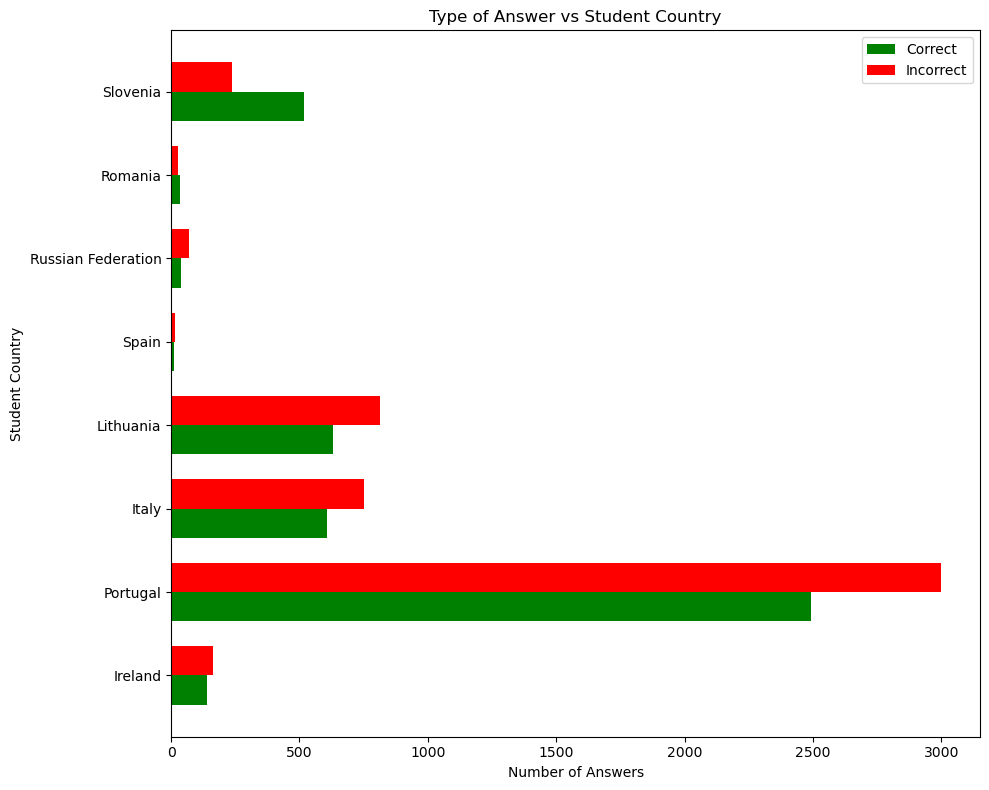

In [150]:
#Type of Answer vs Student Country
uniqueCountries = list(df['Student Country'].unique())
countryCorrectAnswers = []
countryIncorrectAnswers = []

for country in uniqueCountries:
    correct = df[(df["Type of Answer"] == 1) & (df["Student Country"] == country)].shape[0]
    incorrect = df[(df["Type of Answer"] == 0) & (df["Student Country"] == country)].shape[0]
    countryCorrectAnswers.append(correct)
    countryIncorrectAnswers.append(incorrect)

y = list(range(len(uniqueCountries)))
bar_height = 0.35

y_correct = []
y_incorrect = []
for i in y:
    y_correct.append(i - bar_height / 2)
    y_incorrect.append(i + bar_height / 2)

plt.figure(figsize=(10, 8))
plt.barh(y_correct, countryCorrectAnswers, height=bar_height, label="Correct", color="green")
plt.barh(y_incorrect, countryIncorrectAnswers, height=bar_height, label="Incorrect", color="red")

plt.yticks(ticks=y, labels=uniqueCountries)
plt.title("Type of Answer vs Student Country")
plt.xlabel("Number of Answers")
plt.ylabel("Student Country")
plt.legend()
plt.tight_layout()
plt.show()

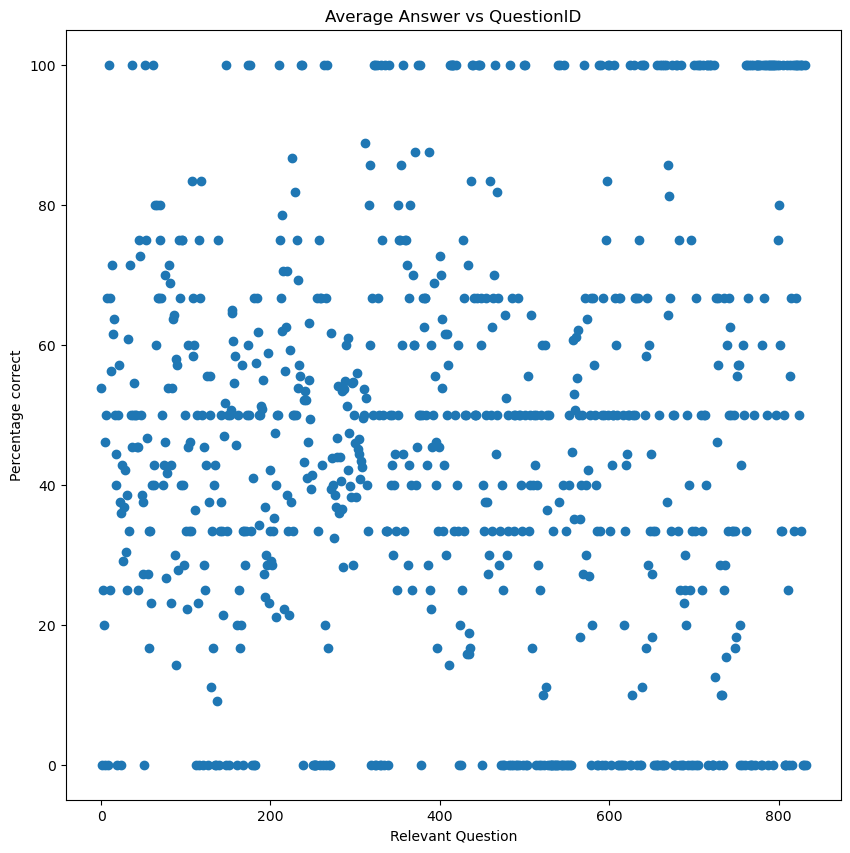

In [151]:
#Type of Answer vs questionID
x = range(df["Question ID"].unique().size)
y = []
for question in df["Question ID"].unique():
    maskAnswer = df["Question ID"] == question
    y.append(np.mean(df["Type of Answer"][maskAnswer])*100)

plt.figure(figsize = (10,10))
plt.title("Average Answer vs QuestionID")
plt.ylabel("Percentage correct")
plt.xlabel("Relevant Question")
plt.scatter(x, y)
#plt.xticks(df["Question ID"].unique())
plt.show()

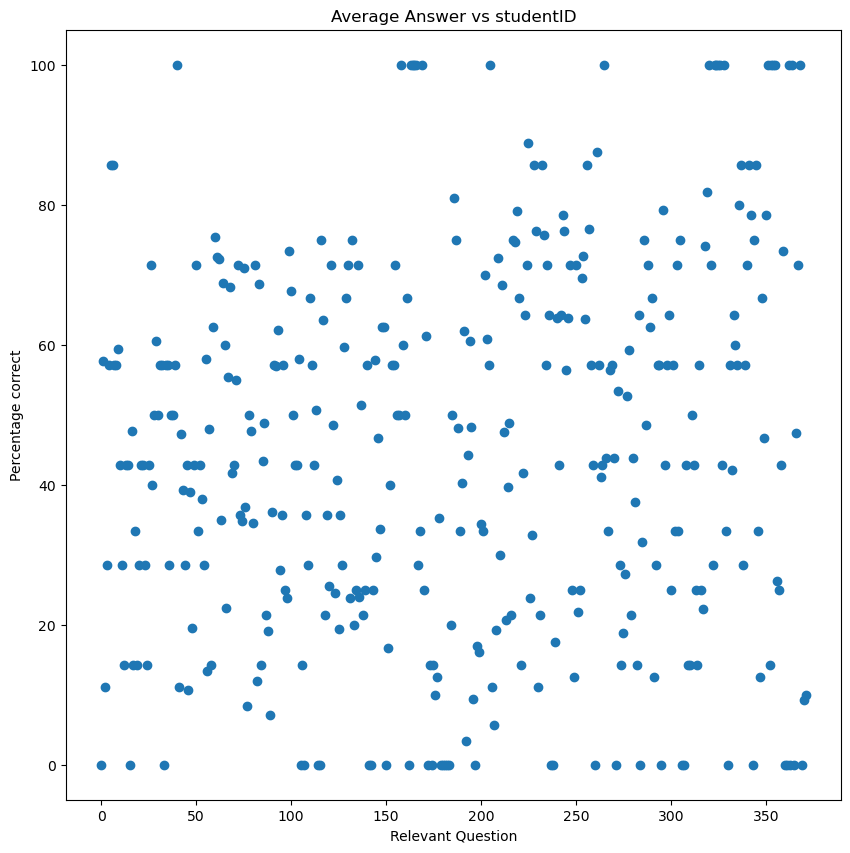

In [152]:
#Type of Answer vs studentID
x = range(df["Student ID"].unique().size)
y = []
for student in df["Student ID"].unique():
    maskAnswer = df["Student ID"] == student
    y.append(np.mean(df["Type of Answer"][maskAnswer])*100)

plt.figure(figsize = (10,10))
plt.title("Average Answer vs studentID")
plt.ylabel("Percentage correct")
plt.xlabel("Relevant Question")
plt.scatter(x, y)
#plt.xticks(df["Question ID"].unique())
plt.show()

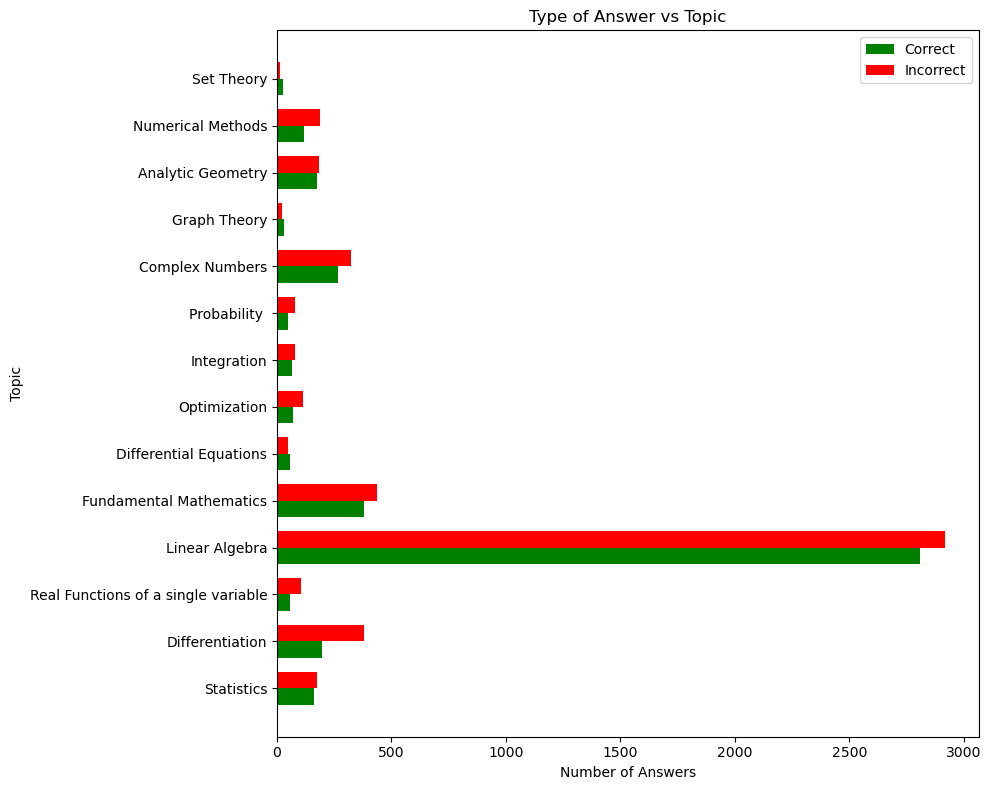

In [153]:
#Type of Answer vs Topic
uniqueTopics = list(df['Topic'].unique())
topicCorrectAnswers = []
topicIncorrectAnswers = []

for topic in uniqueTopics:
    correct = df[(df["Type of Answer"] == 1) & (df["Topic"] == topic)].shape[0]
    incorrect = df[(df["Type of Answer"] == 0) & (df["Topic"] == topic)].shape[0]
    topicCorrectAnswers.append(correct)
    topicIncorrectAnswers.append(incorrect)

y = list(range(len(uniqueTopics)))
bar_height = 0.35

y_correct = []
y_incorrect = []
for i in y:
    y_correct.append(i - bar_height / 2)
    y_incorrect.append(i + bar_height / 2)

plt.figure(figsize=(10, 8))
plt.barh(y_correct, topicCorrectAnswers, height=bar_height, label="Correct", color="green")
plt.barh(y_incorrect, topicIncorrectAnswers, height=bar_height, label="Incorrect", color="red")

plt.yticks(ticks=y, labels=uniqueTopics)
plt.title("Type of Answer vs Topic")
plt.xlabel("Number of Answers")
plt.ylabel("Topic")
plt.legend()
plt.tight_layout()
plt.show()

# experiment with algorithms, feature sets, parameters, etc.,

In [154]:
#Note: I ran this within the for loops of various criteria and preprocessing below,
#it seems like they don't affect the results much after the dataset is chosen so in implementation I did it right after data choice. 
X = Basicdf.drop('Type of Answer', axis = 1)
y = Basicdf['Type of Answer']

model = DecisionTreeClassifier()
model.fit(X,y)
importance = pd.Series(model.feature_importances_, index=X.columns)
top_features = importance.sort_values(ascending=False).head(10)
print("Top features:")
print(top_features)

Top features:
Question ID        0.350301
Student ID         0.338962
Keywords           0.186725
Student Country    0.054791
Subtopic           0.034595
Topic              0.024082
Question Level     0.010544
dtype: float64


In [226]:
#Decision Trees:
#note- the following are used throughout all models tested, not just decision trees, for easy visualization later
allAttempts = []
allAccuracies = []
allPrecisions = []
allRecalls = []
goodAttempts = []
goodAccuracies = []
goodPrecisions = []
goodRecalls = []
cutoff = 0.64
bestModelKey = ["name", "accuracy", "Precision", "Recall", "Mean Score"]
bestModel = ["",0,0,0,0]

for data, name in zip([Basicdf, MLBdf, TFIDFdf, TFIDF_DRdf], ['Basicdf', 'MLBdf', 'TFIDFdf', 'TFIDF_DRdf']):
    y = data['Type of Answer']

    if (name == 'TFIDFdf') or (name == 'MLBdf'):
        X = data.drop('Type of Answer', axis = 1)
        model = DecisionTreeClassifier()
        model.fit(X,y)
        importance = pd.Series(model.feature_importances_, index=X.columns)
        top_features = importance.sort_values(ascending=False).head(8)
        tempx = []
        for feature, score in top_features.items():
            tempx.append(X[feature])
        X = pd.concat(tempx, axis = 1)
    else:
        X = data.drop(['Type of Answer', 'Question Level', 'Topic', 'Subtopic'], axis = 1)
    
    combos = []
    for i in range(1,len(X.columns)+1):
        combos += combinations(X.columns, i)
    
    for criterion in ["gini", "entropy", "log_loss"]:
        for combination in combos:
            tempx = []
            for col in combination:
                tempx.append(X[col])
            tempx = pd.concat(tempx , axis = 1)
            
            model = DecisionTreeClassifier(criterion = criterion)
            tempy = cross_val_predict(model, tempx, y, cv=5)
            
            acc = accuracy_score(y, tempy)
            pre = precision_score(y, tempy, average='macro', zero_division=0)
            rec = recall_score(y, tempy, average='macro', zero_division=0)

            combo_label = name + " " + criterion + " " + ' '.join(combination)
            allAttempts.append(combo_label)
            allAccuracies.append(acc)
            allPrecisions.append(pre)
            allRecalls.append(rec)
            
            if((acc > cutoff) and (pre > cutoff) and (rec > cutoff)):
                goodAttempts.append(combo_label)
                goodAccuracies.append(acc)
                goodPrecisions.append(pre)
                goodRecalls.append(rec)
                if(np.mean([acc, pre, rec]) > bestModel[4]):
                    bestModel[0] = combo_label
                    bestModel[1] = acc
                    bestModel[2] = pre
                    bestModel[3] = rec
                    bestModel[4] = np.mean([acc, pre, rec])

In [227]:
#Random Forest
for data, name in zip([Basicdf, MLBdf, TFIDFdf, TFIDF_DRdf], ['Basicdf', 'MLBdf', 'TFIDFdf', 'TFIDF_DRdf']):
    X = data.drop('Type of Answer', axis = 1)
    y = data['Type of Answer']
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    model = RandomForestClassifier(random_state=42)
    
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    acc = cv_results['test_accuracy'].mean()
    pre = cv_results['test_precision'].mean()
    rec = cv_results['test_recall'].mean()

    name = "Random Forest on " + name
    allAttempts.append(name)
    allAccuracies.append(acc)
    allPrecisions.append(pre)
    allRecalls.append(rec)
    if((acc > cutoff) and (pre > cutoff) and (rec > cutoff)):
        goodAttempts.append(name)
        goodAccuracies.append(acc)
        goodPrecisions.append(pre)
        goodRecalls.append(rec)
        if(np.mean([acc, pre, rec]) > bestModel[4]):
            bestModel[0] = name
            bestModel[1] = acc
            bestModel[2] = pre
            bestModel[3] = rec
            bestModel[4] = np.mean([acc, pre, rec])

# visualize experimental results

In [228]:
print(bestModelKey)
for i, score in enumerate(bestModel[1:4]):
    bestModel[i+1] = round(score,3)
print(bestModel)

['name', 'accuracy', 'Precision', 'Recall', 'Mean Score']
['MLBdf gini Student ID Topic Question Level', 0.65, 0.648, 0.648, 0.6486862536469659]


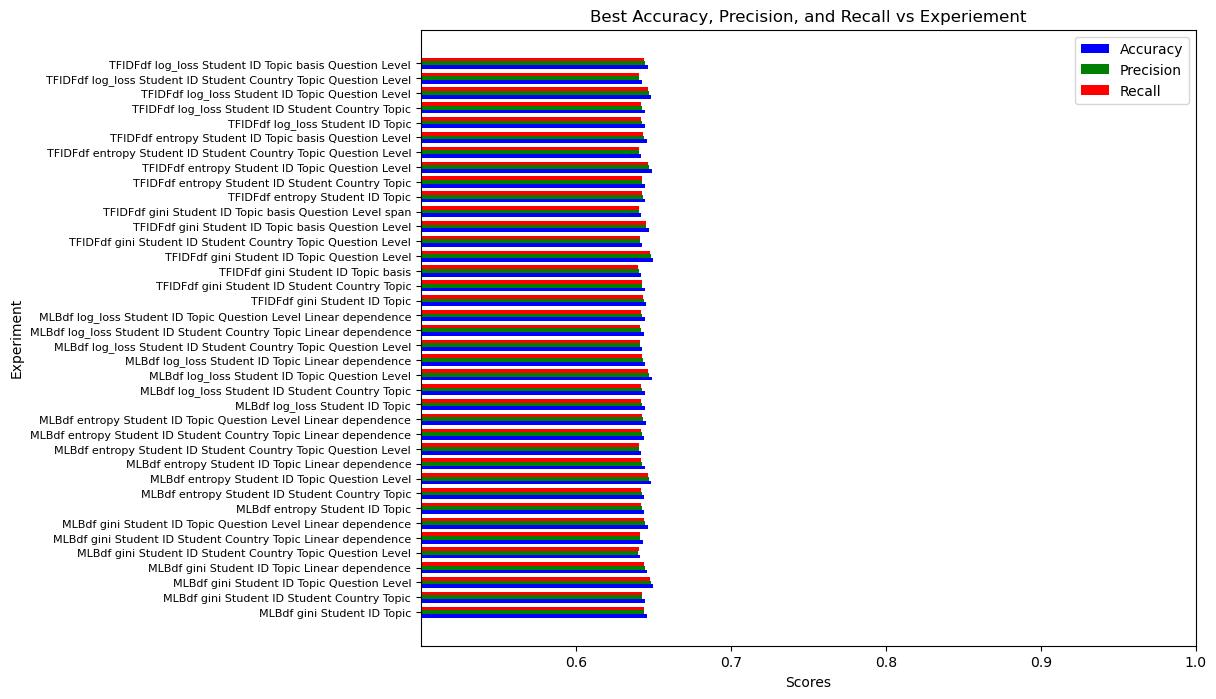

In [229]:
index = np.arange(len(goodAttempts))
bar_width = 0.25
plt.figure(figsize = (10,8))
plt.barh(index - bar_width, goodAccuracies, bar_width, label='Accuracy', color='b')
plt.barh(index, goodPrecisions, bar_width, label='Precision', color='g')
plt.barh(index + bar_width, goodRecalls, bar_width, label='Recall', color='r') 
plt.xlim(.5,1)
plt.xticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel("Scores")
plt.ylabel("Experiment")
plt.yticks(index, goodAttempts, fontsize=8)
plt.title("Best Accuracy, Precision, and Recall vs Experiement")
plt.legend()
plt.show()

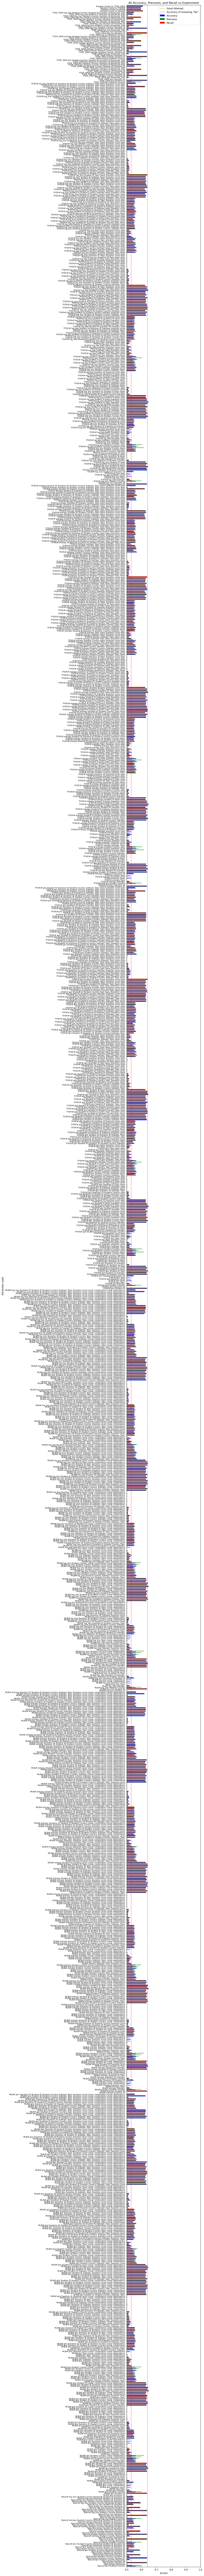

In [230]:
# Determine the actual vertical range
spacing = 1.1
index = np.arange(len(allAttempts)) * spacing
fig_height = len(allAttempts) * spacing * 0.25

plt.figure(figsize=(12, 150))

plt.barh(index - bar_width, allAccuracies, bar_width, label='Accuracy', color='b')
plt.barh(index, allPrecisions, bar_width, label='Precision', color='g')
plt.barh(index + bar_width, allRecalls, bar_width, label='Recall', color='r')

plt.axvline(x=cutoff, color='g', linestyle='--', linewidth=1, label = "Good Attempt")
plt.axvline(x=0.53, color='r', linestyle='--', linewidth=1, label = "Accuracy of Guessing \"No\"")

plt.yticks(index, allAttempts, fontsize=8)
plt.xlabel("Scores")
plt.ylabel("Attributes used")
plt.title("All Accuracy, Precision, and Recall vs Experiment")
plt.xlim(0.5, 1.0)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.ylim(index[0] - bar_width * 3, index[-1] + bar_width * 3)

plt.legend()
plt.tight_layout()
plt.show()


# analyze / explain experimental results

Nothing worked very well, my expectation is that it's due to a lack of predictive power in the dataset as a whole. It would be cool to be able to predict how well someone will do just baesd on these simple attributes about their origin and the question they're asked, but there's so much more at play in this real world example. Realistically we would probably need a lot more information about the individuals. Data about their previous test scores in various subjects, experience in the field, etc. could be much more powerful tools for prediction. That isn't to say the data gathered is meaningless - the paper unpacks some cool data analytics out of it - but it might not be the best for extracting whether or not they're likely to get an answer to a particular question correct.

I honestly have no idea why random forests are performing so poorly on this dataset. This is the first time I've coded one so I may have missed some key parameters that I missed varying or I may have otherwise messed up the implementation of this model. I did expect it to outperform the decision tree both from the information in the slides and from my outside research comparing decision trees vs random forests. They did still significantly outperform chance which is nice at least.

The uniformity/patterns within the data presented is a little bit concerning as to the validity of the models presented but I have looked over all of the model creation and can't find any errors. It does make sense given that they are all coming from the same, slightly altered data set with very similar features chosen and models built, but it feels "off" compared to the other models I've made.

As for what worked to an extent: The majority of tested models performed better than a coin toss (which would be an uninformed prediction of whether someone would answer a question correctly) and better than the 53% accuracy of guessing incorrect every time as the data suggests. I'm definitely happy about this as the model is able to make some successful gains in all scoring metrics.

Of the models that made the "cutoff" (0.64% or higher accuracy, precision, and recall), the following stats were observed:
0/50 used a Random Forest
0/50 used the Basic dataset - it's good to know all the work wasn't quite for nothing!
0/50 used the TF-IDF Reduced Dimensionality dataset - also the most complicated one was unsuccessful!
16/50 used the TF-IDF dataset
34/50 used the MLB dataset - there were way more possible and descriptive options for the "keywords" parameter broken up in this dataset, so it makes sense that more specificity and combination options appeared in good models. 

I think the reason TF-IDF out performed TF-IDF Reduced Dimensionality (significantly) is because in reducing the dimensions we lost some of the specificity that came from the TF-IDF setup. I originally decided to try the reduced dimensionality because I was scared of how sparse the data from the TF-IDF was, but it seems like the decision trees handled it relatively well. On the contrary, when we condensed the data from the TF-IDF into one feature, it lost a lot of the applicability.

I suppose it's worth mentioning why the basic dataset didn't perform as well - there is just a lot of information lost in the oversimplification of the keywords feature. It's truly not fair to consider "Population,Variance,Median,Standard deviation,Mode,Quantile,Sample,Mean" and "Mean,Median,Mode" as two completely unrelated, nominal data points, even with the connection given between them both being in the Statistics subtype. This was not surprising and I expected it to be an issue far before I started building models, but I kept it in the model creations to confirm the suspicion I had.

The Topic feature was used in all but one of the "good" attribute sets. The one that didn't use it was the only "successful" model to use subtopic, seemingly being just good enough to pass through. It also had 6 features chosen (Student ID Student Country Subtopic Question Level and Dimension) which is on the upper end.

Many of the models performed quite well (comparatively) with just studentID and topic which is a cool connection!


The best model found was:
MLB data, gini criterion, features Student ID, Topic, and Question Level
Results:
Accuracy: 65%
Precision: 64.8%
Recall: 64.8%
Mean Score: 64.9%

I expect this performed the best due to the basic features chosen with minimal overlap that covers nearly all of the presented data. It is a little bit sad that it doesn't even touch any of the work I did on the Keywords parameter, but sometimes simple works the best!

Potential things I'm interested in trying in the future:
- More detailed look into how random forests work, I'm pretty convinced I missed something in my implementation
- Experimenting with other model types
- Experimenting with more parameter control within the decision trees I've already built
- Other methods of handling the keyword parameter, maybe connecting it to the topic and subtopic parameters somehow
- Experimenting with decision trees with more of the features included - I limited it to 8 for the sake of the code ever finishing running but I'm sure there's better models to be found

# conclusion 

Despite no model achieving high predictive performance, this project revealed valuable insights into the structure and limitations behind the mathE data analyzed. Simpler models using core features like Student ID and Topic outperformed more complex ones, suggesting that overcomplicating inputs gives diminishing returns at best. Ignoring a few outliers, the models presented beat chance, validating the approach. Future exploration into model tuning, alternate features, and better keyword encoding may yield further improvements.